# First tests

In [25]:
import pandas as pd
from preprocessing import prepare_data

X_train, X_test, y_train, y_test, protected_train, protected_test = prepare_data()

In [7]:
print(y_train)

0        0
1        0
2        0
3        0
4        0
        ..
32556    0
32557    1
32558    0
32559    0
32560    1
Name: income, Length: 30718, dtype: int64


## I. Régression logistique standard

In [26]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=1000)

clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

In [27]:
from sklearn.metrics import classification_report

report = classification_report(y_test,y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.88      0.93      0.90     11543
           1       0.73      0.60      0.66      3772

    accuracy                           0.85     15315
   macro avg       0.80      0.77      0.78     15315
weighted avg       0.84      0.85      0.84     15315



In [29]:
from fair_metrics import intersectional_demographic_parity
idp, considered = intersectional_demographic_parity(y_pred,protected_test)
idp

np.float64(0.18446659990134678)

In [16]:
from fairlearn.metrics import demographic_parity_difference

idp_fairlearn = demographic_parity_difference(y_test,y_pred,sensitive_features=protected_test)
idp_fairlearn

np.float64(0.18446659990134678)

In [17]:
def intersectional_p_percent(proportion_dict):
    prop_max, prop_min, groups_considered = _find_minmax_proportions(proportion_dict)

    return prop_min / prop_max, groups_considered

In [18]:
p_per = intersectional_p_percent(prop)
p_per

(np.float64(0.32110243151061724), ('Asian-Pac-Islander', 'Amer-Indian-Eskimo'))

## DLP avec Fairlearn

In [ ]:
from fairlearn.reductions import ExponentiatedGradient,DemographicParity

constraint = DemographicParity()

clf_fair = ExponentiatedGradient(
    estimator=LogisticRegression(solver="liblinear"),
    constraints=constraint,
    eps=0.02  # tolérance fairness (à explorer)
)

clf_fair.fit(
    X_train,
    y_train,
    sensitive_features=protected_train
)

y_pred_fair = clf_fair.predict(X_test)

In [ ]:
fair_report = classification_report(y_test,y_pred_fair)
print(fair_report)

              precision    recall  f1-score   support

           0       0.81      0.92      0.86     11543
           1       0.57      0.34      0.42      3772

    accuracy                           0.77     15315
   macro avg       0.69      0.63      0.64     15315
weighted avg       0.75      0.77      0.75     15315



In [ ]:
fair_prop = compute_protected_proportions(protected_test,y_pred_fair)
fair_idp = intersectional_demographic_parity(fair_prop)

fair_idp

(np.float64(0.017328144784627297), ('Amer-Indian-Eskimo', 'Black'))

In [ ]:
fair_p_per = intersectional_p_percent(fair_prop)
fair_p_per

(np.float64(0.8924211011287722), ('Amer-Indian-Eskimo', 'Black'))

In [ ]:
y_pred_prob = clf.predict_proba(X_test)[:,1]
y_pred_fair_prob = clf_fair._pmf_predict(X_test)[:,1]

In [ ]:
y_pred_fair_prob

array([0.        , 0.02672403, 0.77315537, ..., 0.22684463, 0.        ,
       0.22684463], shape=(15315,))

### Plot

In [ ]:
race_clf = LogisticRegression(max_iter=1000)

y_white = (protected_train == 'White').astype(int)

race_clf.fit(X_train,y_white)
white_proba = race_clf.predict_proba(X_test)[:,1]

In [ ]:
df_viz = pd.DataFrame({
    'race': protected_test.reset_index(drop=True),
    'p_unconstrained': y_pred_prob,       # clf.predict_proba(X_test)[:,1]
    'p_fair': y_pred_fair_prob,          # fairlearn predict_proba[:,1]
    'p_white': white_proba 
})

threshold = 0.5

# effet individuel
def effect(row):
    if row['p_unconstrained'] < threshold <= row['p_fair']:
        return 'admitted because of treatment'
    elif row['p_unconstrained'] >= threshold > row['p_fair']:
        return 'rejected because of treatment'
    else:
        return 'unchanged'

df_viz['effect'] = df_viz.apply(effect, axis=1)

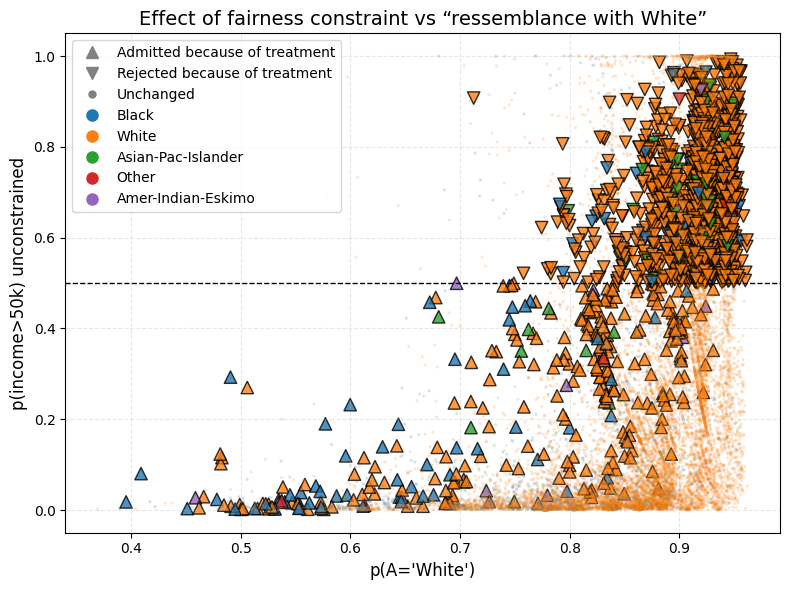

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

marker_map = {
    'admitted because of treatment': '^',
    'rejected because of treatment': 'v',
    'unchanged': 'o'
}

races = df_viz['race'].unique()
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
color_map = dict(zip(races, colors))

plt.figure(figsize=(8,6))
ax = plt.gca()
ax.set_facecolor('white')
ax.grid(True, linestyle='--', alpha=0.3)

for effect_type in ['admitted because of treatment', 'rejected because of treatment', 'unchanged']:
    subset = df_viz[df_viz['effect'] == effect_type]
    size = 80 if effect_type != 'unchanged' else 5
    alpha = 0.8 if effect_type != 'unchanged' else 0.2
    edgecolor = 'k' if effect_type != 'unchanged' else 'none'
    
    plt.scatter(
        subset['p_white'],
        subset['p_unconstrained'],
        marker=marker_map[effect_type],
        color=[color_map[r] for r in subset['race']],
        s=size,
        edgecolor=edgecolor,
        alpha=alpha
    )

plt.axhline(y=0.5, color='black', linestyle='--', linewidth=1)

plt.xlabel("p(A='White')", fontsize=12)
plt.ylabel('p(income>50k) unconstrained', fontsize=12)
plt.title('Effect of fairness constraint vs “ressemblance with White”', fontsize=14)

legend_elements = []
# triangles
legend_elements.append(mlines.Line2D([], [], color='gray', marker='^', linestyle='None', markersize=8, label='Admitted because of treatment'))
legend_elements.append(mlines.Line2D([], [], color='gray', marker='v', linestyle='None', markersize=8, label='Rejected because of treatment'))
legend_elements.append(mlines.Line2D([], [], color='gray', marker='o', linestyle='None', markersize=5, label='Unchanged'))
# couleurs
for race, color in color_map.items():
    legend_elements.append(mlines.Line2D([], [], color=color, marker='o', linestyle='None', markersize=8, label=race))

plt.legend(handles=legend_elements, loc='upper left', fontsize=10, frameon=True)
plt.tight_layout()
plt.show()


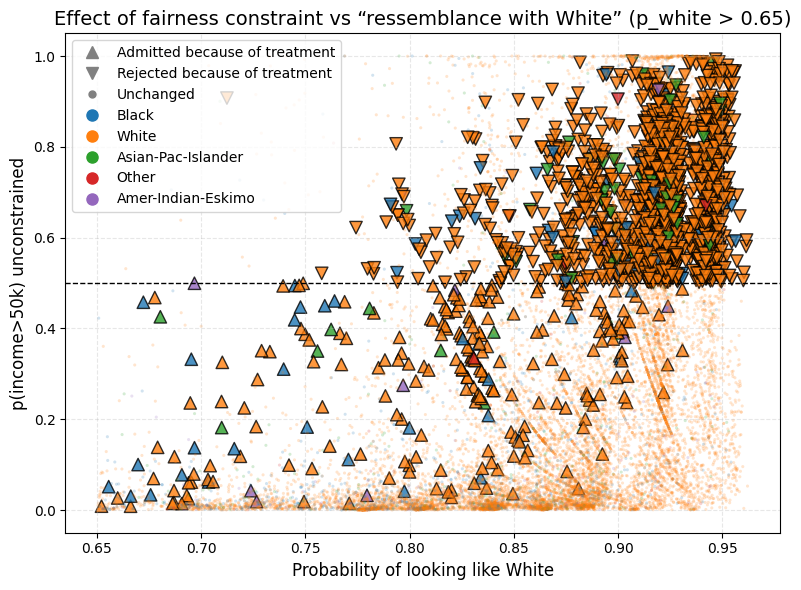

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# Filtrer les individus avec p_white > 0.65
df_viz_zoom = df_viz[df_viz['p_white'] > 0.65]

marker_map = {
    'admitted because of treatment': '^',
    'rejected because of treatment': 'v',
    'unchanged': 'o'
}

# Couleurs sobres par race
races = df_viz_zoom['race'].unique()
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
color_map = dict(zip(races, colors))

plt.figure(figsize=(8,6))
ax = plt.gca()
ax.set_facecolor('white')
ax.grid(True, linestyle='--', alpha=0.3)

for effect_type in ['admitted because of treatment', 'rejected because of treatment', 'unchanged']:
    subset = df_viz_zoom[df_viz_zoom['effect'] == effect_type]
    size = 80 if effect_type != 'unchanged' else 5
    alpha = 0.8 if effect_type != 'unchanged' else 0.2
    edgecolor = 'k' if effect_type != 'unchanged' else 'none'
    
    plt.scatter(
        subset['p_white'],
        subset['p_unconstrained'],
        marker=marker_map[effect_type],
        color=[color_map[r] for r in subset['race']],
        s=size,
        edgecolor=edgecolor,
        alpha=alpha
    )

plt.axhline(y=0.5, color='black', linestyle='--', linewidth=1)

plt.xlabel('Probability of looking like White', fontsize=12)
plt.ylabel('p(income>50k) unconstrained', fontsize=12)
plt.title('Effect of fairness constraint vs “ressemblance with White” (p_white > 0.65)', fontsize=14)

# Légende
legend_elements = []
# Triangles
legend_elements.append(mlines.Line2D([], [], color='gray', marker='^', linestyle='None', markersize=8, label='Admitted because of treatment'))
legend_elements.append(mlines.Line2D([], [], color='gray', marker='v', linestyle='None', markersize=8, label='Rejected because of treatment'))
legend_elements.append(mlines.Line2D([], [], color='gray', marker='o', linestyle='None', markersize=5, label='Unchanged'))
# Couleurs
for race, color in color_map.items():
    legend_elements.append(mlines.Line2D([], [], color=color, marker='o', linestyle='None', markersize=8, label=race))

plt.legend(handles=legend_elements, loc='best', fontsize=10, frameon=True)
plt.tight_layout()
plt.show()


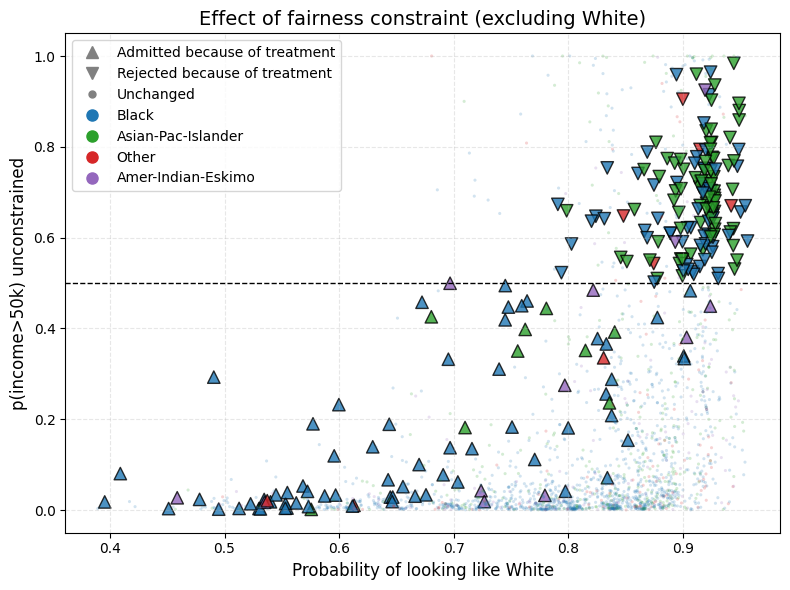

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# Filtrer les individus qui ne sont pas White
df_viz_nonwhite = df_viz[df_viz['race'] != 'White']

marker_map = {
    'admitted because of treatment': '^',
    'rejected because of treatment': 'v',
    'unchanged': 'o'
}

# Couleurs sobres par race
races = df_viz_nonwhite['race'].unique()
colors = ['#1f77b4', '#2ca02c', '#d62728', '#9467bd']  # exclu le bleu utilisé pour White
color_map = dict(zip(races, colors))

plt.figure(figsize=(8,6))
ax = plt.gca()
ax.set_facecolor('white')
ax.grid(True, linestyle='--', alpha=0.3)

for effect_type in ['admitted because of treatment', 'rejected because of treatment', 'unchanged']:
    subset = df_viz_nonwhite[df_viz_nonwhite['effect'] == effect_type]
    size = 80 if effect_type != 'unchanged' else 5
    alpha = 0.8 if effect_type != 'unchanged' else 0.2
    edgecolor = 'k' if effect_type != 'unchanged' else 'none'
    
    plt.scatter(
        subset['p_white'],                  # axe X = probabilité de ressembler à White
        subset['p_unconstrained'],          # axe Y = probabilité revenu>50k unconstrained
        marker=marker_map[effect_type],
        color=[color_map[r] for r in subset['race']],
        s=size,
        edgecolor=edgecolor,
        alpha=alpha
    )

plt.axhline(y=0.5, color='black', linestyle='--', linewidth=1)

plt.xlabel('Probability of looking like White', fontsize=12)
plt.ylabel('p(income>50k) unconstrained', fontsize=12)
plt.title('Effect of fairness constraint (excluding White)', fontsize=14)

# Légende
legend_elements = []
# Triangles
legend_elements.append(mlines.Line2D([], [], color='gray', marker='^', linestyle='None', markersize=8, label='Admitted because of treatment'))
legend_elements.append(mlines.Line2D([], [], color='gray', marker='v', linestyle='None', markersize=8, label='Rejected because of treatment'))
legend_elements.append(mlines.Line2D([], [], color='gray', marker='o', linestyle='None', markersize=5, label='Unchanged'))
# Couleurs par race (non-White)
for race, color in color_map.items():
    legend_elements.append(mlines.Line2D([], [], color=color, marker='o', linestyle='None', markersize=8, label=race))

plt.legend(handles=legend_elements, loc='best', fontsize=10, frameon=True)
plt.tight_layout()
plt.show()


/tmp/ipykernel_687812/4126324853.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_viz_nonwhite= df_viz_nonwhite[df_viz['p_white'] > 0.65]


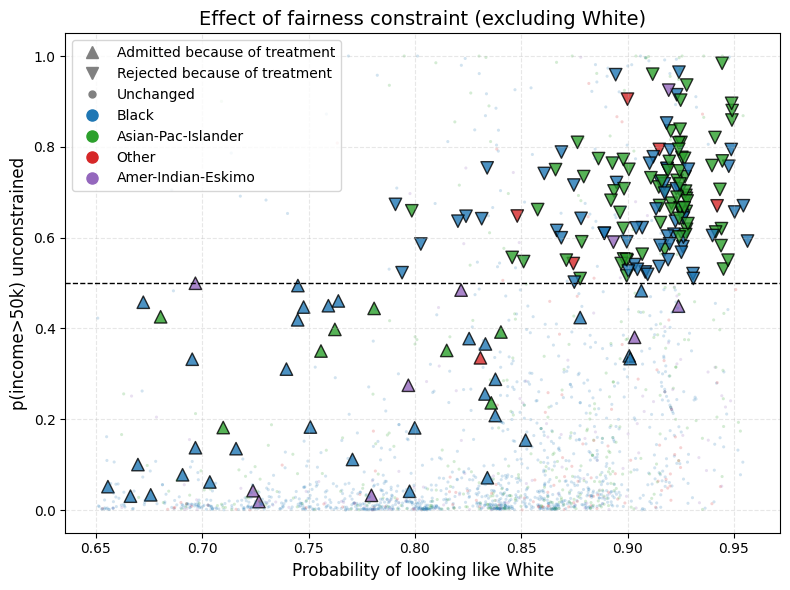

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# Filtrer les individus qui ne sont pas White
df_viz_nonwhite = df_viz[df_viz['race'] != 'White']
df_viz_nonwhite= df_viz_nonwhite[df_viz['p_white'] > 0.65]

marker_map = {
    'admitted because of treatment': '^',
    'rejected because of treatment': 'v',
    'unchanged': 'o'
}

# Couleurs sobres par race
races = df_viz_nonwhite['race'].unique()
colors = ['#1f77b4', '#2ca02c', '#d62728', '#9467bd']  # exclu le bleu utilisé pour White
color_map = dict(zip(races, colors))

plt.figure(figsize=(8,6))
ax = plt.gca()
ax.set_facecolor('white')
ax.grid(True, linestyle='--', alpha=0.3)

for effect_type in ['admitted because of treatment', 'rejected because of treatment', 'unchanged']:
    subset = df_viz_nonwhite[df_viz_nonwhite['effect'] == effect_type]
    size = 80 if effect_type != 'unchanged' else 5
    alpha = 0.8 if effect_type != 'unchanged' else 0.2
    edgecolor = 'k' if effect_type != 'unchanged' else 'none'
    
    plt.scatter(
        subset['p_white'],                  # axe X = probabilité de ressembler à White
        subset['p_unconstrained'],          # axe Y = probabilité revenu>50k unconstrained
        marker=marker_map[effect_type],
        color=[color_map[r] for r in subset['race']],
        s=size,
        edgecolor=edgecolor,
        alpha=alpha
    )

plt.axhline(y=0.5, color='black', linestyle='--', linewidth=1)

plt.xlabel('Probability of looking like White', fontsize=12)
plt.ylabel('p(income>50k) unconstrained', fontsize=12)
plt.title('Effect of fairness constraint (excluding White)', fontsize=14)

# Légende
legend_elements = []
# Triangles
legend_elements.append(mlines.Line2D([], [], color='gray', marker='^', linestyle='None', markersize=8, label='Admitted because of treatment'))
legend_elements.append(mlines.Line2D([], [], color='gray', marker='v', linestyle='None', markersize=8, label='Rejected because of treatment'))
legend_elements.append(mlines.Line2D([], [], color='gray', marker='o', linestyle='None', markersize=5, label='Unchanged'))
# Couleurs par race (non-White)
for race, color in color_map.items():
    legend_elements.append(mlines.Line2D([], [], color=color, marker='o', linestyle='None', markersize=8, label=race))

plt.legend(handles=legend_elements, loc='best', fontsize=10, frameon=True)
plt.tight_layout()
plt.show()

## Treatment disparity

In [19]:
from treatment_disparity import MulticlassThresholdOptimizer

best_fair_clf = MulticlassThresholdOptimizer(protected_test)

y_pred = best_fair_clf.fit_transform(X_train,y_train,X_test,gamma=0.001)

In [20]:
report = classification_report(y_test,y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.91      0.82      0.86     11543
           1       0.57      0.75      0.65      3772

    accuracy                           0.80     15315
   macro avg       0.74      0.78      0.75     15315
weighted avg       0.83      0.80      0.81     15315



In [22]:
best_fair_prop = compute_protected_proportions(protected_test,y_pred)
best_fair_idp = intersectional_demographic_parity(best_fair_prop)

best_fair_idp

(np.float64(0.0009433663316673613), ('Asian-Pac-Islander', 'White'))

In [23]:
best_fair_prop

{'White': np.float64(0.3219965000380431),
 'Black': np.float64(0.32204561161022804),
 'Other': np.float64(0.3228346456692913),
 'Asian-Pac-Islander': np.float64(0.32293986636971045),
 'Amer-Indian-Eskimo': np.float64(0.3221476510067114)}

In [24]:
best_fair_p_per = intersectional_p_percent(best_fair_prop)
best_fair_p_per

(np.float64(0.9970788173591818), ('Asian-Pac-Islander', 'White'))